# TrySelectingMetricSpatially #

**Started 2016-04-27** -- Try loading a previously-evaluated metric and selecting on spatial regions.

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [27]:
# healpy 
import healpy as hp

In [5]:
# Loading pre-ran metric results
import lsst.sims.maf.metricBundles as mb

In [6]:
# import statements from the plot-handling notebook
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup, makeBundlesDictFromList

In [28]:
# Copied file sims_utils/python/lsst/sims/utils/healpyUtils.py into the working directory
import healpyUtils

### Set the source path for precomputed metric output ###

In [7]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository.

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#metricDir = '%s/data/metricOutputs' % (topDir)

# Otherwise we assume this is already being run from the directory 
# holding pre-computed metric directories.
metricDir=os.getcwd()

In [8]:
# Let's set metricDir to a particular place...
inputDir='%s/metricEvals/minion_1016_nside64_ugrizy_n10000_r21p0_lims' % (metricDir)
inputFil='minion_1016_properMotion_night_lt_10000_HEAL.npz'

## Test loading pre-computed metric ##

In [9]:
# check that we can read the path
inPath = '%s/%s' % (inputDir, inputFil)
print os.access(inPath, os.R_OK)

True


In [10]:
myBundle = mb.createEmptyMetricBundle()

In [11]:
myBundle.read(inPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Test plotting the spatial map for this metric bundle ##

In [17]:
print myBundle.metric.name

properMotion


In [18]:
print myBundle.metric.colInfo

In [19]:
# Can we choose which plots to produce?
# help(myBundle.setPlotFuncs)   ## Yes but is not immediately obvious to me...
print myBundle.plotFuncs  # can we change this?
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()] #, plots.HealpixSDSSSkyMap()]
myBundle.setPlotFuncs(plotFuncs)

[<lsst.sims.maf.plots.spatialPlotters.HealpixSkyMap object at 0x1152a6f90>, <lsst.sims.maf.plots.spatialPlotters.HealpixHistogram object at 0x115355050>]


{'Histogram': 2, 'SkyMap': 1}

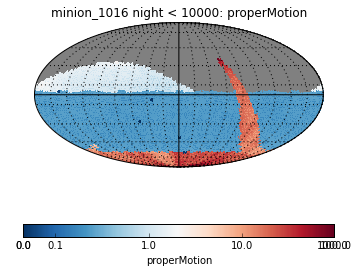

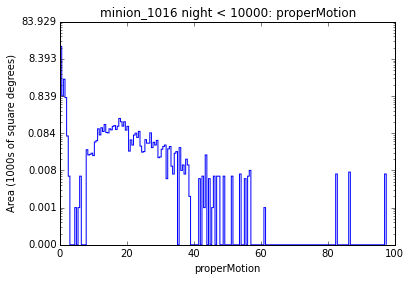

In [20]:
# aha - so we CAN just plot by calling the method!! Niiice... OK now see if we can change any parameters
thisPlotDict = {'logScale':True, 'cmap':cm.RdBu_r}
myBundle.setPlotDict(thisPlotDict)
myBundle.plot()

## Try lifting spatial information out ## 

Following an idea suggested by Peter Yoachim using healpy and healpyUtils.py to do co-ordinate conversion

In [31]:
npix = myBundle.metricValues.size
nside = hp.npix2nside(npix)
print npix, nside

49152 64


In [35]:
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
print np.shape(ra)
print np.shape(dec)

(49152,)
(49152,)


### Can we test-plot these values?? ###

In [36]:
np.shape(myBundle.metricValues)

(49152,)

In [60]:
print myBundle.metric.colRegistry

## Next steps##

Try manipulating the spatial information using something we're more familiar with, like astropy.

**To be continued...**